In [13]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import csv
import pandas as pd
import random

In [21]:
routers = []
radials = None

def P_r(r):
    # Friss function for actual signal at router
    P_r = P_t + 20 * np.log10(c / (4* np.pi* f* r))
    return P_r

c = 299792458
f = 2.4 * 10**9
Z = 2 # height of router - height of device

 
def triangulate(used_routers, signals):
    #print("TRIANGULATING!!!! WOOOO")
    global routers, radials
    routers = used_routers
    radials = [SiToR(Si) for Si in signals]
    triangulate = minimize(locationScore, [10,10])
    measuredx, measuredy = triangulate.x
    pos = (measuredx, measuredy)
    
    xerror, yerror = 0, 0
    for router in routers:
        x, y = router
        deltax = x - measuredx
        deltay = y - measuredy
        r = getR(measuredx, measuredy, x, y)
        xerror += getError(deltax, r)
        yerror += getError(deltay, r)
    uncertainty = (xerror,yerror)
    return pos, uncertainty

def plot_pos_uncertainty(pos, uncertainty, fig, ax):
    (x,y) = pos
    (width, height) = uncertainty
    ellipse = matplotlib.patches.Ellipse(pos, width, height, linewidth=1, fc='b', fill=True, alpha=0.3)
    ax.plot(x,y, 'o')
    plt.axis([0,20,0,20])
    ax.add_artist(ellipse)
    

def getR(S_x, S_y, x_i, y_i):
    # Get R from x-, y-, z values
    return math.sqrt((S_x - x_i)**2 + (S_y - y_i)**2 + Z**2)

def SiToR(Si):
    # Get radius from measured signal
    return c/(4*math.pi*f*10**(Si/20.0))
    
def locationScore(xy):
    # Function that scores the goodness of the 
    # current xy position for optimize function
    global routers, radials
    x, y = xy
    score = 0
    for n, r in enumerate(routers):
        routerx = r[0]
        routery = r[1]
        tryRadial2 = (x - routerx)**2 + (y - routery)**2
        score += (radials[n]**2 - tryRadial2)**2
    return score

def getError(d, r):
    # Get error on one delta x or delta y (d) value
    # r is the radius
    return -20/math.log(10)*d/r
    

In [16]:
#configuring the coordinates of the routers
named_routers = {
            "Lima": (5.82, 5.48),
            "Mike": (11.33, 9.43),
            "Kilo": (12.39, 6.77),
            "Oscar": (2.48, 7.36),
            "Alpha": (8.53, 2.16),
            "India": (2.18, 5.61),
            "November": (8.34, 4.13),
            "Hotel": (5.43, 4.71),
            "Romeo": (10.99, 5.94),
            "Quebec": (6.82, 9.78),
            "Papa": (9.9, 10.39)
          }

In [17]:
fname = 'UvA-wifitracking-exercise-prepped-data.csv'

df = pd.read_csv(fname)
packets = df.groupby(['typeNr', 'subTypeNr', 'seqNr'])


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


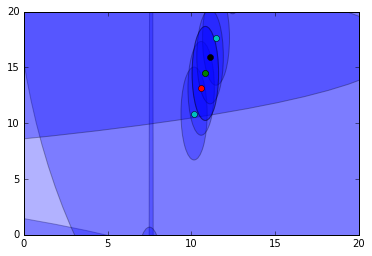

In [22]:
positions = []

#rebuild the routers list per packet
# routers = [(0,0), (0,20), (20,20), (20, 0)]


fig, ax = plt.subplots()
for packet in packets:
#     print(packet[1][['droneId', 'signal']])
#     print(type(packet[1]))
    routers = []
    signals = []
    for row in packet[1].iterrows():
        droneId = row[1].loc['droneId']
        signal =  row[1].loc['signal']
        routers.append(named_routers[droneId])
        signals.append(signal)
    #print(routers, signals)
    pos, uncertainty = triangulate(routers, signals) 
    plot_pos_uncertainty(pos, uncertainty, fig, ax)
fig.show()
    
        